In [ ]:
!pip install tensorflow scikit-learn joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Room_2/Room2_npy'

X, y, shapes = [], [], []

for activity in sorted(os.listdir(dataset_path)):
    folder = os.path.join(dataset_path, activity)
    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith(".npy"):
                data = np.load(os.path.join(folder, file))
                data = np.real(data)
                if data.ndim == 2:
                    shapes.append(data.shape)
                    X.append(data)
                    y.append(activity)

print("Loaded:", len(X), "samples")

# Optional: Limit dataset to avoid memory crash
max_samples = 1000
if len(X) > max_samples:
    X = X[:max_samples]
    y = y[:max_samples]
    print(f"Using subset of data: {max_samples} samples")

Loaded: 114 samples


In [ ]:
max_rows = max(s[0] for s in shapes)
max_cols = max(s[1] for s in shapes)

X = np.array([np.pad(d, ((0, max_rows - d.shape[0]), (0, max_cols - d.shape[1])), mode='constant') for d in X], dtype=np.float32)
y = np.array(y)

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_val, y_train_cat, y_val_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [ ]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.2)(x)
feature_layer = Dense(32, activation='relu', name='feature_layer')(x)
output_layer = Dense(y_cat.shape[1], activation='softmax')(feature_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = datetime.now()
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                    epochs=20, batch_size=32, callbacks=[early_stop])
end_time = datetime.now()

print(f"\n⏱️ Total Training Time: {(end_time - start_time).total_seconds() / 60:.2f} minutes")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 215s 68s/step - accuracy: 0.1582 - loss: 2.0656 - val_accuracy: 0.1739 - val_loss: 2.0567
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 200s 67s/step - accuracy: 0.2849 - loss: 1.9082 - val_accuracy: 0.2174 - val_loss: 2.0135
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 215s 73s/step - accuracy: 0.4410 - loss: 1.8206 - val_accuracy: 0.3478 - val_loss: 1.9854
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 213s 70s/step - accuracy: 0.5521 - loss: 1.7252 - val_accuracy: 0.3478 - val_loss: 1.9751
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 260s 70s/step - accuracy: 0.6218 - loss: 1.6241 - val_accuracy: 0.3913 - val_loss: 1.9497
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 270s 72s/step - accuracy: 0.6422 - loss: 1.5363 - val_accuracy: 0.4348 - val_loss: 1.9100
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 260s 70s/step - accuracy: 0.7549 - loss: 1.4023 - val_accuracy: 0.4348 - val_loss: 1.8569
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 253s 70s/step - accuracy: 0.7174 - loss: 1.3199 - val_accuracy: 0.4348 - val_loss:

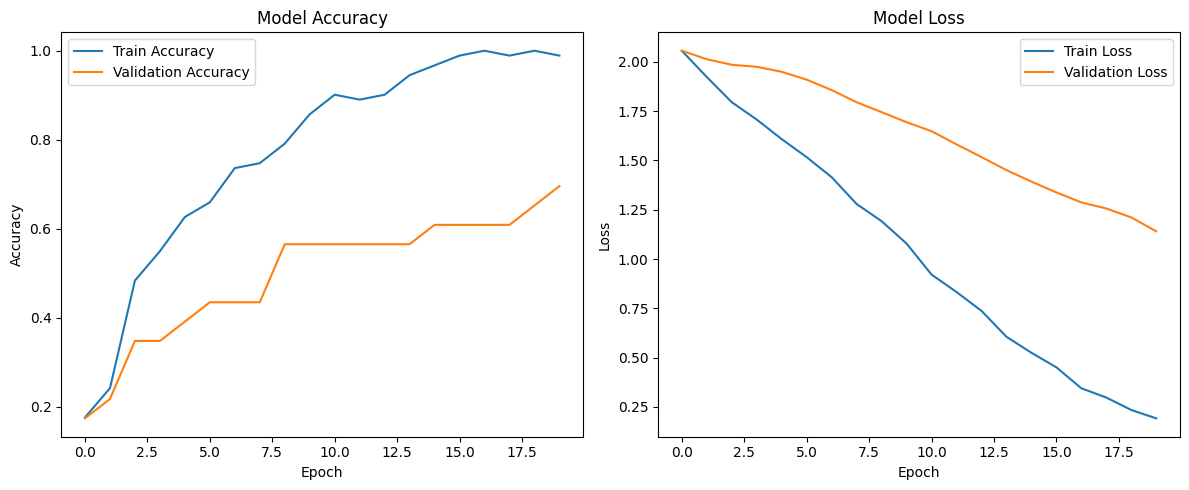

In [9]:
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

In [10]:
feature_model = Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)
features = feature_model.predict(X, batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step


In [11]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(features, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

# Logistic Regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_svm, y_train_svm)
y_pred_logreg = log_reg.predict(X_test_svm)

# SVM Classifier
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_svm, y_train_svm)
y_pred_svm = svm_classifier.predict(X_test_svm)

In [12]:
def evaluate_classifier(name, y_true, y_pred):
    print(f"\n📊 {name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    print(f"✅ {name} Accuracy: {accuracy_score(y_true, y_pred):.4f}")

evaluate_classifier("Logistic Regression", y_test_svm, y_pred_logreg)
evaluate_classifier("SVM", y_test_svm, y_pred_svm)


📊 Logistic Regression Classification Report:

              precision    recall  f1-score   support

       kneel       0.50      1.00      0.67         2
     liedown       1.00      0.50      0.67         4
      pickup       0.33      1.00      0.50         1
         sit       0.80      1.00      0.89         4
   sitrotate       1.00      1.00      1.00         2
       stand       1.00      0.67      0.80         6
 standrotate       1.00      0.33      0.50         3
        walk       0.50      1.00      0.67         1

    accuracy                           0.74        23
   macro avg       0.77      0.81      0.71        23
weighted avg       0.87      0.74      0.74        23

✅ Logistic Regression Accuracy: 0.7391

📊 SVM Classification Report:

              precision    recall  f1-score   support

       kneel       0.50      1.00      0.67         2
     liedown       1.00      0.50      0.67         4
      pickup       0.33      1.00      0.50         1
         sit   

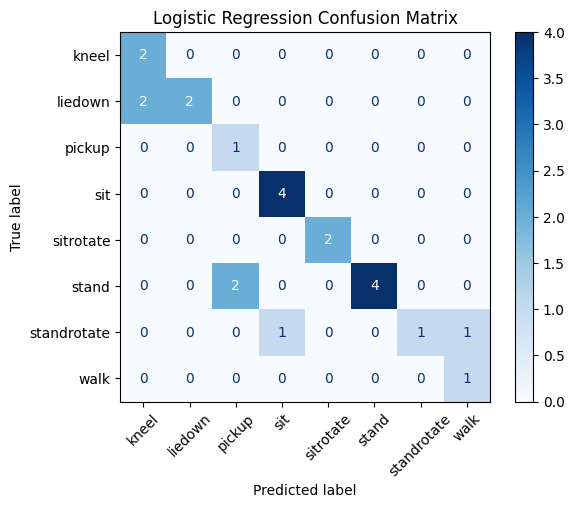

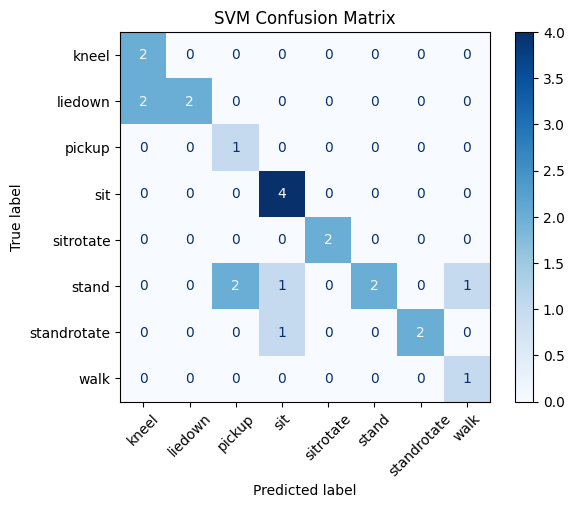

In [13]:
def plot_confusion_mat(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.show()

plot_confusion_mat(y_test_svm, y_pred_logreg, le.classes_, "Logistic Regression Confusion Matrix")
plot_confusion_mat(y_test_svm, y_pred_svm, le.classes_, "SVM Confusion Matrix")